In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Harry Potter and the Chamber of Secrets.txt to Harry Potter and the Chamber of Secrets.txt


In [3]:
file = open("Harry Potter and the Chamber of Secrets.txt", "r", encoding = "utf8")


lines = []
for i in file:
    lines.append(i)

data = ""
for i in lines:
  data = ' '. join(lines)


data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space


data = data.split()
data = ' '.join(data)
data[:500]

'Harry Potter and the Chamber of Secrets By J.K. Rowling CHAPTER ONE The Worst Birthday Not for the first time, an argument had broken out over breakfast at number four, Privet Drive. Mr. Vernon Dursley had been woken in the early hours of the morning by a loud, hooting noise from his nephew Harry’s room. Third time this week! he roared across the table. If you can’t control that owl, it’ll have to go! Harry tried, yet again, to explain. She’s bored, he said. She’s used to flying around outside. '

In [4]:
len(data)

482392

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]
len(sequence_data)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)

print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])

X = np.array(X)
y = np.array(y)
print("Data: ", X[:10])
print("Response: ", y[:10])
y = to_categorical(y, num_classes=vocab_size)
y[:5]

7427
The Length of sequences are:  86704
Data:  [[   6  102    2]
 [ 102    2    1]
 [   2    1  145]
 [   1  145    5]
 [ 145    5  238]
 [   5  238   64]
 [ 238   64 2938]
 [  64 2938 4102]
 [2938 4102 4103]
 [4102 4103  589]]
Response:  [   1  145    5  238   64 2938 4102 4103  589   51]


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             74270     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 7427)              7434427   
                                                                 
Total params: 20,557,697
Trainable params: 20,557,697
Non-trainable params: 0
_________________________________________________________________


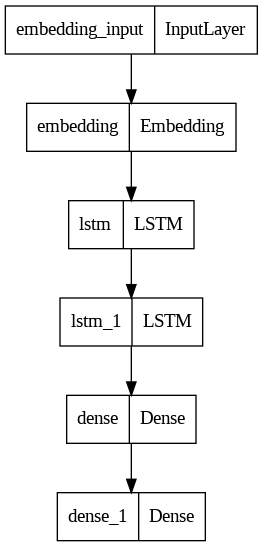

In [7]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=70, batch_size=64, callbacks=[checkpoint])


Epoch 1/70
1355/1355 [==============================] - ETA: 0s - loss: 6.7123
Epoch 1: loss improved from inf to 6.71235, saving model to next_words.h5
1355/1355 [==============================] - 37s 20ms/step - loss: 6.7123
Epoch 2/70
1355/1355 [==============================] - ETA: 0s - loss: 6.1899
Epoch 2: loss improved from 6.71235 to 6.18988, saving model to next_words.h5
1355/1355 [==============================] - 21s 16ms/step - loss: 6.1899
Epoch 3/70
1355/1355 [==============================] - ETA: 0s - loss: 5.8381
Epoch 3: loss improved from 6.18988 to 5.83815, saving model to next_words.h5
1355/1355 [==============================] - 21s 16ms/step - loss: 5.8381
Epoch 4/70
1353/1355 [============================>.] - ETA: 0s - loss: 5.5438
Epoch 4: loss improved from 5.83815 to 5.54356, saving model to next_words.h5
1355/1355 [==============================] - 21s 15ms/step - loss: 5.5436
Epoch 5/70
1355/1355 [==============================] - ETA: 0s - loss: 5.2892
E

In [9]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""

  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break

  print(predicted_word)
  return predicted_word
while(True):
  text = input("Enter your line: ")

  if text == "0":
      print("Execution completed.....")
      break

  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)

          Predict_Next_Words(model, tokenizer, text)

      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: breakfast at number
['breakfast', 'at', 'number']
1/1 [==============================] - 1s 671ms/step
four
Enter your line: Harry Potter is
['Harry', 'Potter', 'is']
1/1 [==============================] - 0s 21ms/step
greater
Enter your line: He who must
['He', 'who', 'must']
1/1 [==============================] - 0s 19ms/step
not
Enter your line: Ron Weasley is
['Ron', 'Weasley', 'is']
1/1 [==============================] - 0s 22ms/step
that
Enter your line: Harry Potter and 
['Potter', 'and', '']
1/1 [==============================] - 1s 645ms/step
he
Enter your line: Harry Potter and
['Harry', 'Potter', 'and']
1/1 [==============================] - 0s 21ms/step
with
Enter your line: Harry Potter and the Chamber of
['the', 'Chamber', 'of']
1/1 [==============================] - 0s 28ms/step
secrets
Enter your line: Chamber of
['Chamber', 'of']
1/1 [==============================] - 0s 21ms/step
course
Enter your line: 0
Execution completed.....
